In [94]:
import pandapower as pp
from pandapower import plotting
from pandapower.plotting import simple_plotly, pf_res_plotly
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math
import numba
import seaborn


net = pp.create_empty_network() # creating network


In [95]:
# summer scenario 
  # date = 9 Aug 2019 @ 13:31
  # max demand = 1303 MW

# winter scenario
  # date = 22 Jan 2019 @ 20.24
  # max demand = 956 MW

#create 18 buses
bus_df=pd.read_excel('1059042_Balearic_islands_my_stuff.xlsx',sheet_name=0)

b = []

for i in bus_df['bus_id']:
    b.append(pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0])))
    

In [96]:
# create the grid connection point to mainland this will then act as the slack bus.
connect_bus = b[1]
vm_pu = 1

pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")


0

In [97]:
#net.bus

In [98]:
# create all of the transformers for the system - there will be three here, as below

# bus 1 Santa Ponca (132) / bus 2 Santa Ponca (220)
#hv_bus = b[2]
#lv_bus = b[1]
#sn_mva = 320    
#vn_hv_kv = 132
#vn_lv_kv = 220
#vk_percent = 12
#vkr_percent = 0.26
#pfe_kw = 55
#i0_percent = 0.06 
#pp.create_transformer(net, hv_bus=b[2], lv_bus=b[1], std_type='100 MVA 220/110 kV')
pp.create_transformer_from_parameters(net, hv_bus=b[2], lv_bus=b[1], sn_mva=320, vn_hv_kv=220, vn_lv_kv=132, vkr_percent=0.26, vk_percent=12, pfe_kw=55, i0_percent=0.06)


# bus 5 Portol (Cas Tresorer) (220) / bus 6 Portol (Cas Tresorer) (66)
#hv_bus = b[5]
#lv_bus = b[6]
#sn_mva = 480
#vn_hv_kv = 220
#vn_lv_kv = 66
#vk_percent = 12
#vkr_percent = 0.26
#pfe_kw = 55
#i0_percent = 0.06
pp.create_transformer_from_parameters(net, hv_bus=b[5], lv_bus=b[6], sn_mva=480, vn_hv_kv=220, vn_lv_kv=66, vkr_percent=0.26, vk_percent=12, pfe_kw=55, i0_percent=0.06)


# bus 10 Es Bessons (220) /  bus 11 Es Bessons (132)
#hv_bus = b[10]
#lv_bus = b[11]
# used parameters from 100 MVA 220/110 kV standard type
#sn_mva = 446 
#vn_hv_kv = 220
#vn_lv_kv = 132
#vk_percent = 12
#vkr_percent = 0.26
#pfe_kw = 55
#i0_percent = 0.06
pp.create_transformer_from_parameters(net, hv_bus=b[10], lv_bus=b[11], sn_mva=446, vn_hv_kv=220, vn_lv_kv=132, vkr_percent=0.26, vk_percent=12, pfe_kw=55, i0_percent=0.06)



2

In [99]:
#net.trafo

In [100]:
#create the lines and pull all of the information out of the spreadsheet

line_df=pd.read_excel('1059042_Balearic_islands_my_stuff.xlsx',sheet_name=3)

l = []

#create the geodata for the cables this can then be used later to import into QGIS.

loc_b0=(1.430833, 38.91917)
loc_b1=(2.506454, 39.53525)
loc_b2=(2.507937, 39.53662)
loc_b3=(2.549167, 39.58417)
loc_b4=(2.678889, 39.65083)
loc_b5=(2.724617, 39.56686)
loc_b6=(2.724617, 39.56686)
loc_b7=(2.744444, 39.60028)
loc_b8=(3.039444, 39.67333)
loc_b9=(3.0925, 39.80944)
loc_b10=(3.158056, 39.58194)
loc_b11=(3.159638, 39.58209)
loc_b12=(3.427024, 39.73827)
loc_b13=(3.834227, 39.93175)
loc_b14=(3.855278, 40.00333)
loc_b15=(4.095556, 39.97694)
loc_b16=(4.236667, 39.89111)
loc_b17=(4.258155, 39.89706)

#Note to remember - the number of cables will determine the characteristics of the wires.

#Cable Type Underwater - r_ohm_per_km=underwater_r, x_ohm_per_km=underwater_x, c_nf_per_km=underwater_c,max_i_ka=underwater_a
underwater_r =0.053
underwater_x = 0.119
underwater_c = 1.700000e-09
underwater_a = 0.545
#Cable Type Condor - r_ohm_per_km=condor_r, x_ohm_per_km=condor_x, c_nf_per_km=condor_c,max_i_ka=condor_a
condor_r =0.021
condor_x = 0.32
condor_c = 1.00e-09
condor_a = 0.975
#Cable Type Peacock - r_ohm_per_km=peacock_r, x_ohm_per_km=peacock_x, c_nf_per_km=peacock_c,max_i_ka=peacock_a
peacock_r = 0.031823
peacock_x = 0.325366
peacock_c = 1.00e-09
peacock_a = 0.83
#Cable Type Pelican - r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a
pelican_r = 0.040567
pelican_x = 0.329077
pelican_c = 1.00e-09
pelican_a = 0.7
#Cable Type Merlin - r_ohm_per_km=merlin_r, x_ohm_per_km=merlin_x, c_nf_per_km=merlin_c,max_i_ka=merlin_a
merlin_r = 0.05
merlin_x = 0.33485
merlin_c = 1.00e-09
merlin_a = 0.56
#Cable Type Waxwing - r_ohm_per_km=waxwing_r, x_ohm_per_km=waxwing_x, c_nf_per_km=waxwing_c,max_i_ka=waxwing_a
waxwing_r = 0.0723
waxwing_x = 0.338219
waxwing_c = 1.00e-09
waxwing_a = 0.48
#Cable Type Pigeon -  r_ohm_per_km=pigeon_r, x_ohm_per_km=pigeon_x, c_nf_per_km=pigeon_c,max_i_ka=pigeon_a
pigeon_r = 0.112867
pigeon_x = 0.345464
pigeon_c = 1.00e-09
pigeon_a = 0.34
#Cable Type Raven - r_ohm_per_km=raven_r, x_ohm_per_km=raven_x, c_nf_per_km=raven_c,max_i_ka=raven_a
raven_r = 0.179
raven_x = 0.353
raven_c = 1.00e-09
raven_a = 0.255

#Create all of the wires with the parameters and also add the geodata into them
#0
pp.create_line_from_parameters(net, from_bus=b[0],to_bus=b[1],length_km=126, r_ohm_per_km=underwater_r, x_ohm_per_km=underwater_x, c_nf_per_km=underwater_c,max_i_ka=underwater_a, geodata=[loc_b0, loc_b1]) 
#1
pp.create_line_from_parameters(net, from_bus=b[2],to_bus=b[3],length_km=5.599, r_ohm_per_km=raven_r, x_ohm_per_km=raven_x, c_nf_per_km=raven_c,max_i_ka=raven_a, geodata=[loc_b2, loc_b3]) 
#2
pp.create_line_from_parameters(net, from_bus=b[3],to_bus=b[4],length_km=15.025, r_ohm_per_km=raven_r, x_ohm_per_km=raven_x, c_nf_per_km=raven_c,max_i_ka=raven_a, geodata=[loc_b3, loc_b4]) 
#3
pp.create_line_from_parameters(net, from_bus=b[3],to_bus=b[4],length_km=14.89,r_ohm_per_km=merlin_r, x_ohm_per_km=merlin_x, c_nf_per_km=merlin_c,max_i_ka=merlin_a, geodata=[loc_b3, loc_b4]) 
#4
pp.create_line_from_parameters(net, from_bus=b[4],to_bus=b[7],length_km=9.41, r_ohm_per_km=merlin_r, x_ohm_per_km=merlin_x, c_nf_per_km=merlin_c,max_i_ka=merlin_a, geodata=[loc_b4, loc_b7]) 
#5
pp.create_line_from_parameters(net, from_bus=b[4],to_bus=b[8],length_km=33.83,r_ohm_per_km=raven_r, x_ohm_per_km=raven_x, c_nf_per_km=raven_c,max_i_ka=raven_a, geodata=[loc_b4, loc_b8])
#6
pp.create_line_from_parameters(net, from_bus=b[7],to_bus=b[5],length_km=4.35, r_ohm_per_km=condor_r, x_ohm_per_km=condor_x, c_nf_per_km=condor_c,max_i_ka=condor_a, geodata=[loc_b7, loc_b5]) 
#7
pp.create_line_from_parameters(net, from_bus=b[7],to_bus=b[8],length_km=28.9, r_ohm_per_km=merlin_r, x_ohm_per_km=merlin_x, c_nf_per_km=merlin_c,max_i_ka=merlin_a, geodata=[loc_b7, loc_b8]) 
#8
pp.create_line_from_parameters(net, from_bus=b[8],to_bus=b[9],length_km=16.7, r_ohm_per_km=peacock_r, x_ohm_per_km=peacock_x, c_nf_per_km=peacock_c,max_i_ka=peacock_a, geodata=[loc_b8, loc_b9]) 
#9
pp.create_line_from_parameters(net, from_bus=b[9],to_bus=b[9],length_km=16.06, r_ohm_per_km=peacock_r, x_ohm_per_km=peacock_x, c_nf_per_km=peacock_c,max_i_ka=peacock_a, geodata=[loc_b8, loc_b9]) 
#10
pp.create_line_from_parameters(net, from_bus=b[8],to_bus=b[10],length_km=15.177, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b8, loc_b10]) 
#11
pp.create_line_from_parameters(net, from_bus=b[8],to_bus=b[10],length_km=14.95, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b8, loc_b10]) 
#12
pp.create_line_from_parameters(net, from_bus=b[11],to_bus=b[12],length_km=30.27, r_ohm_per_km=peacock_r, x_ohm_per_km=peacock_x, c_nf_per_km=peacock_c,max_i_ka=peacock_a, geodata=[loc_b11, loc_b12]) 
#13
pp.create_line_from_parameters(net, from_bus=b[12],to_bus=b[13],length_km=52.94, r_ohm_per_km=underwater_r, x_ohm_per_km=underwater_x, c_nf_per_km=underwater_c,max_i_ka=underwater_a, geodata=[loc_b12, loc_b13]) 
#14
pp.create_line_from_parameters(net, from_bus=b[13],to_bus=b[14],length_km=8.2, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b13, loc_b14]) 
#15
pp.create_line_from_parameters(net, from_bus=b[14],to_bus=b[16],length_km=35.5, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b14, loc_b16]) 
#16
pp.create_line_from_parameters(net, from_bus=b[14],to_bus=b[15],length_km=21.13, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b14, loc_b15]) 
#17
pp.create_line_from_parameters(net, from_bus=b[15],to_bus=b[16],length_km=15.43, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b15, loc_b16]) 
#18
pp.create_line_from_parameters(net, from_bus=b[16],to_bus=b[17],length_km=4.71, r_ohm_per_km=pelican_r, x_ohm_per_km=pelican_x, c_nf_per_km=pelican_c,max_i_ka=pelican_a, geodata=[loc_b16, loc_b17]) 

18

In [101]:
#net.line

In [102]:
# create the loads by pulling all of the information through the excel.

load_df=pd.read_excel('1059042_Balearic_islands_my_stuff.xlsx',sheet_name=1)


p_mw_s = 'summer_p_mw'
q_mvar_s = 'summer_q_mvar'

for i in load_df['bus_id']:
    pp.create_load(net, 
                 b[i], 
                 p_mw=load_df.loc[load_df['bus_id']==i, p_mw_s].values[0], 
                 q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar_s].values[0])

In [103]:
#net.load

In [104]:
#With this section add """ below and remove the """ at the bottom of the page to view the generation with solar PV generation.

#The generation below is for the island at the summer peak without the solar generation required for 80% of the islands daily energy.

#pulling in information from excel spreadsheet we will first look at the current condition of the island where demand and generation is peak. 

gen_df=pd.read_excel('1059042_Balearic_islands_my_stuff.xlsx',sheet_name=2)

p_mw = 'gen_at_peak_summer'
  
for i in gen_df['bus_connection']:
    pp.create_gen(net, 
                b[i], 
                p_mw = gen_df.loc[gen_df['bus_connection']==i, 'actual_gen_pro_rata'].values[0], 
                vm_pu=vm_pu,   # defined above
                name= gen_df.loc[gen_df['bus_connection']==i,'name'].values[0])
    
"""
#The below shows the required solar PV generation to provide the island with 80% of it's daily energy for the specific day.

gen_df=pd.read_excel('1059042_Balearic_islands_my_stuff_PV.xlsx',sheet_name=2)

p_mw = 'gen_at_peak_summer_PV'
  
for i in gen_df['bus_connection']:
    pp.create_gen(net, 
                b[i],
                p_mw = gen_df.loc[gen_df['bus_connection']==i,'actual_gen_pro_rata'].values[0], 
                vm_pu=vm_pu,   # defined above
                name= gen_df.loc[gen_df['bus_connection']==i,'name'].values[0])
"""

"\n#The below shows the required solar PV generation to provide the island with 80% of it's daily energy for the specific day.\n\ngen_df=pd.read_excel('1059042_Balearic_islands_my_stuff_PV.xlsx',sheet_name=2)\n\np_mw = 'gen_at_peak_summer_PV'\n  \nfor i in gen_df['bus_connection']:\n    pp.create_gen(net, \n                b[i],\n                p_mw = gen_df.loc[gen_df['bus_connection']==i,'actual_gen_pro_rata'].values[0], \n                vm_pu=vm_pu,   # defined above\n                name= gen_df.loc[gen_df['bus_connection']==i,'name'].values[0])\n"

In [105]:
#net.gen

In [106]:
#run the powerflow through the Gaus Seidel 

pp.runpp(net, algorithm='gs')

In [139]:
#net.res_trafo

In [133]:
#net.line

In [134]:
#net.res_line

In [135]:
#net.res_load

In [136]:
#net.res_bus

The number of given colors (1) is smaller than the number of nodes (18) to draw! The colors will be repeated to fit.


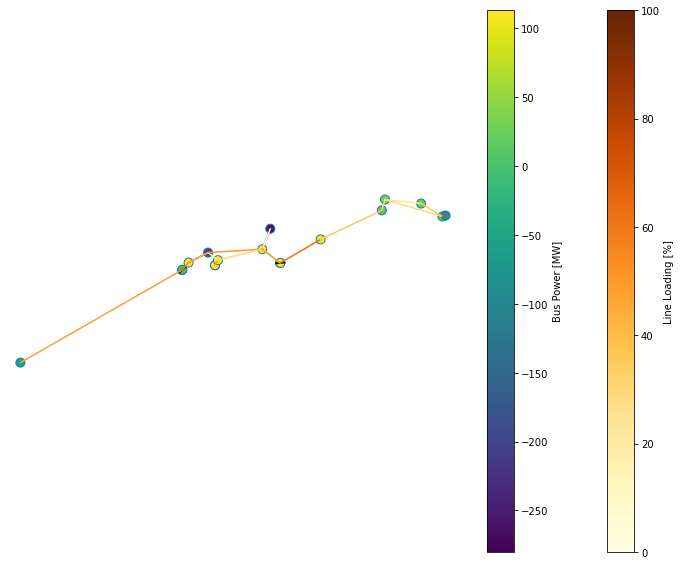

In [140]:
#Now will need to plot the results of the powerflow into a powerflow map - for this I have used the seaborn import from which we can change the colours to ensure much clearer representation of information.

import seaborn
import matplotlib.pyplot as plt


pp.to_excel(net, 'AdamIncSOLARppnet.xlsx')

colors = seaborn.color_palette()

bc = pp.plotting.create_bus_collection(net, buses=net.res_bus.index, size=.03, color=colors[0], patch_type='circle', cmap='viridis', norm=None, \
                                       infofunc=None, picker=False, bus_geodata=None, z=net.res_bus.p_mw, cbar_title='Bus Power [MW]')

lc = pp.plotting.create_line_collection(net, lines=net.res_line.index, line_geodata=None, bus_geodata=None, use_bus_geodata=False,\
                                        infofunc=None, cmap='YlOrBr', norm=None, picker=False, z=None, cbar_title='Line Loading [%]', clim=(0,100), plot_colormap=True)

tc = pp.plotting.create_trafo_collection(net, trafos=net.res_trafo.index, picker=False, size=.02, infofunc=None, norm=None, z=None,
                                            clim=(0,100), cbar_title='Transformer Loading [%]', plot_colormap=True)

pp.plotting.draw_collections([tc, lc, bc])

#plt.show()

pp.plotting.to_html(net, 'AdamExcSOLARppnet.html', respect_switches=True, include_lines=True, include_trafos=True, show_tables=True)
#net.res_line


pp.to_json(net, "AdamIncSOLARppnet.json")


#net.res_line


In [141]:
#net.res_gen

In [142]:
#net.line

In [143]:
pd_line = pd.DataFrame(net.line_geodata)

pd_bus = pd.DataFrame(net.res_bus)
gdf_busloc = gpd.GeoDataFrame(net.bus_geodata, geometry=gpd.points_from_xy(net.bus_geodata.x, net.bus_geodata.y))


pd_bus['geometry'] = gdf_busloc['geometry']

gdf_businfo = gpd.GeoDataFrame(pd_bus, crs="EPSG:4326")

#print(gdf_busloc)
#gdf_busloc.plot()

#now work out the lines after the powerflow as been undertaken and assign the coordinates for each line.

l1 = [*range(0, 19, 1)]
l2 = [*range(0, 19, 1)]


for i in range(0,19) :
    l1[i] = LineString(pd_line['coords'][i])
    l2[i] = i
                    
d = {'col1': l2, 'geometry': l1}


df=pd.DataFrame(d)

pd_lineinfo = pd.DataFrame(net.res_line)

pd_lineinfo['geometry'] = df['geometry']


gdf_lineloc = gpd.GeoDataFrame(pd_lineinfo, crs="EPSG:4326") 

gdf_lineloc.to_file("lineAdamIncSOLARsummer.shp")
gdf_businfo.to_file('busAdamIncSOLARsummer.shp')

#df_businfo.head()

C:\Users\adamg\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\adamg\AppData\Local\Temp/ipykernel_27440/1888714151.py:36: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_lineloc.to_file("lineAdamIncSOLARsummer.shp")
